In [33]:
import numpy
import gym
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [34]:
env=gym.make('Blackjack-v0')
env.action_space, env.observation_space

(Discrete(2), Tuple(Discrete(32), Discrete(11), Discrete(2)))

In [35]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [36]:
def generate_episode(policy, env):
    
    ## state, actions, reward 초기화
    states, actions, rewards = [], [], []
    
    ## gym 환경변수 초기화
    observation = env.reset()
    
    while True:
        
        ## state list에 추가
        states.append(observation)
        
        ##sample policy를 활용하여 action 선택 이후 action list에 추가
        action = sample_policy(observation)
        actions.append(action)
        
        ##위의 action을 통해 다음 state로 이동 및 reward 처리
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        ##state가 terminal인경우
        if done:
            break
            
            
    return states, actions, rewards

In [37]:
def first_visit_mc_prediction(policy, env, n_episodes):
    
    ## value table 초기화 
    value_table = defaultdict(float)
    N = defaultdict(int)
    
    
    for _ in range(n_episodes):
        
        ## policy와 env를 통해 새로운 에피소드생성(state, rewards...)
        states, _ , rewards = generate_episode(policy,env)
        returns = 0
        
        
        ## 하나의 에피소드 생성한 뒤, 하나의 에피소드에 있는 각 스텝에 대해 R, S를 저장하고 sum of rewards를 계산
        for t in range(len(states)-1, -1 , -1):
            R = rewards[t]
            S = states[t]
            returns += R
            
            ## 이미 하나의 에피소드 에서 방문한 state라면 valuetable에 반영하지 않고
            ## 그렇지 않고 방문하지 않았다면 value table에 반영
            if S not in states[:t]:
                N[S]+=1
                value_table[S] += (returns -value_table[S])/N[S]
                
    return value_table
            

In [38]:
def plot_blackjack(V, ax1, ax2):
    player_sum = numpy.arange(12, 21+1)
    dealer_show = numpy.arange(1,10+1)
    usable_ace = numpy.array([False,True])
    state_values = numpy.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i,j,k]=V[player,dealer, ace]
    
    X, Y = numpy.meshgrid(player_sum,dealer_show)
    
    X = numpy.transpose(X)
    Y = numpy.transpose(Y)
    ax1.plot_wireframe(Y, X, state_values[:, :, 0])
    ax2.plot_wireframe(Y, X, state_values[:, :, 1])
    
    for ax in ax1, ax2:
        ax.set_zlim(-1,1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlable('state-value')
        
    

In [39]:
value =first_visit_mc_prediction(sample_policy,env,n_episodes = 100000)

In [40]:
value

defaultdict(float,
            {(4, 1, False): -0.5434782608695653,
             (4, 2, False): -0.3846153846153846,
             (4, 3, False): -0.396551724137931,
             (4, 4, False): -0.5609756097560974,
             (4, 5, False): -0.27906976744186035,
             (4, 6, False): -0.38775510204081626,
             (4, 7, False): -0.5333333333333333,
             (4, 8, False): -0.509090909090909,
             (4, 9, False): -0.3902439024390244,
             (4, 10, False): -0.44886363636363624,
             (5, 1, False): -0.5686274509803921,
             (5, 2, False): -0.43037974683544317,
             (5, 3, False): -0.6222222222222223,
             (5, 4, False): -0.4128440366972478,
             (5, 5, False): -0.5783132530120481,
             (5, 6, False): -0.3867924528301888,
             (5, 7, False): -0.48863636363636365,
             (5, 8, False): -0.33707865168539314,
             (5, 9, False): -0.29885057471264376,
             (5, 10, False): -0.552763819095

AttributeError: 'Axes3DSubplot' object has no attribute 'set_zlable'

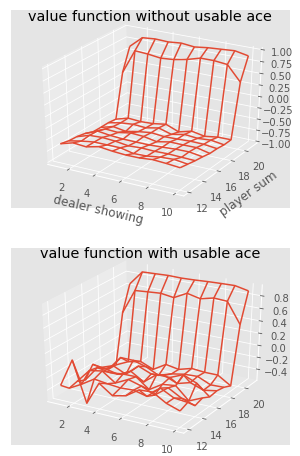

In [41]:
fig , axes = pyplot.subplots(nrows=2, figsize=(5,8),subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0],axes[1])